# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [107]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [109]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [111]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\thoma\AppData\Local\Temp\ipykernel_8840\3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
C:\Users\thoma\AppData\Local\Temp\ipykernel_8840\3482823818.py:7: SettingWithCopyWarning: 
A value is t

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [113]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [115]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

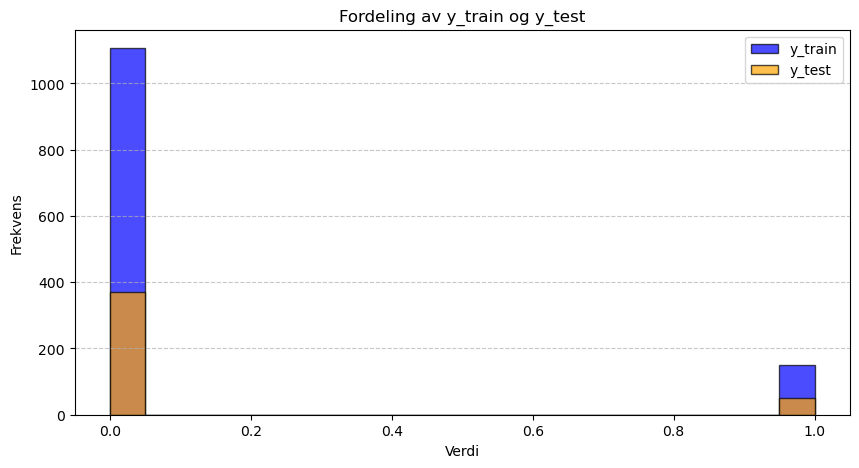

In [117]:
import matplotlib.pyplot as plt

# Forutsetter at `y_train` og `y_test` er definert som arrays eller pandas-serier

# Plot histogrammer
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=20, alpha=0.7, label='y_train', color='blue', edgecolor='black')
plt.hist(y_test, bins=20, alpha=0.7, label='y_test', color='orange', edgecolor='black')
plt.title("Fordeling av y_train og y_test")
plt.xlabel("Verdi")
plt.ylabel("Frekvens")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Svar:**

Basert på figuren er dette klassifisering. Dette er fordi verdiene er diskret satt opp, og har verdiene 0 eller 1. 

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


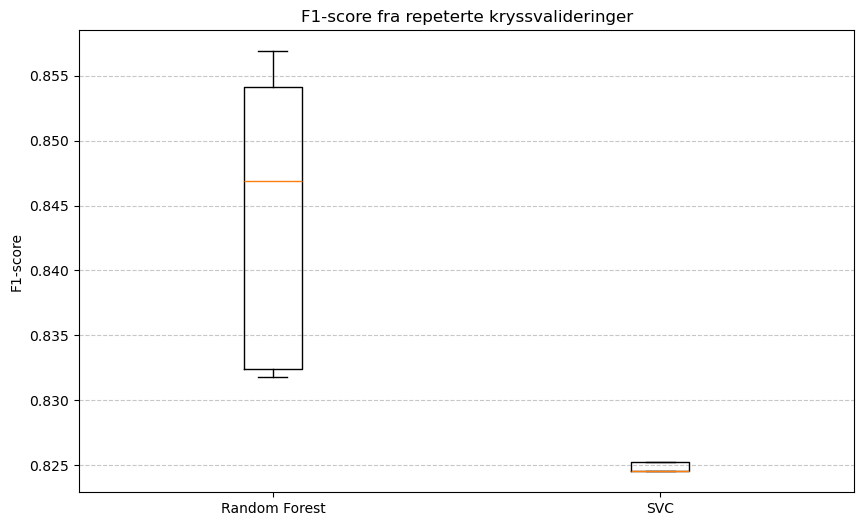

Statistisk test mellom Modell 1 (Random Forest) og Modell 2 (SVC):
T-statistikk: 12.962, P-verdi: 0.000
Det er en signifikant forskjell mellom modellene (p < 0.05).

Gjennomsnittlige F1-skårer:
Random Forest: 0.844 ± 0.011
SVC: 0.825 ± 0.000

Gjennomsnittlige Accuracy-skårer:
Random Forest: 0.885 ± 0.005
SVC: 0.881 ± 0.000


In [119]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# **1. Velg to modeller**
model_1 = RandomForestClassifier(random_state=0)  # Modell 1: Random Forest
model_2 = SVC(random_state=0)                     # Modell 2: Support Vector Machine

# **2. Definer scoringmetrikker**
f1_scorer = make_scorer(f1_score, average='weighted')  # F1-score med vektet gjennomsnitt
accuracy_scorer = make_scorer(accuracy_score)          # Accuracy

# **3. Gjør repeterte kryssvalideringer (10 repetisjoner, K=5)**
n_repeats = 10
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

f1_scores_model_1 = []
f1_scores_model_2 = []

accuracy_scores_model_1 = []
accuracy_scores_model_2 = []

for _ in range(n_repeats):
    # Modell 1: Random Forest
    f1_scores_1 = cross_val_score(model_1, X_train, y_train, cv=kfold, scoring=f1_scorer)
    accuracy_scores_1 = cross_val_score(model_1, X_train, y_train, cv=kfold, scoring=accuracy_scorer)
    f1_scores_model_1.extend(f1_scores_1)
    accuracy_scores_model_1.extend(accuracy_scores_1)
    
    # Modell 2: SVC
    f1_scores_2 = cross_val_score(model_2, X_train, y_train, cv=kfold, scoring=f1_scorer)
    accuracy_scores_2 = cross_val_score(model_2, X_train, y_train, cv=kfold, scoring=accuracy_scorer)
    f1_scores_model_2.extend(f1_scores_2)
    accuracy_scores_model_2.extend(accuracy_scores_2)

# **4. Visualiser F1-skårene som et boksplot**
plt.figure(figsize=(10, 6))
plt.boxplot([f1_scores_model_1, f1_scores_model_2], labels=['Random Forest', 'SVC'])
plt.title('F1-score fra repeterte kryssvalideringer')
plt.ylabel('F1-score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **5. To-sidig T-test for å sammenligne modellene**
t_stat, p_value = ttest_ind(f1_scores_model_1, f1_scores_model_2)

# **6. Tolk resultatene**
print("Statistisk test mellom Modell 1 (Random Forest) og Modell 2 (SVC):")
print(f"T-statistikk: {t_stat:.3f}, P-verdi: {p_value:.3f}")
if p_value < 0.05:
    print("Det er en signifikant forskjell mellom modellene (p < 0.05).")
else:
    print("Det er ingen signifikant forskjell mellom modellene (p ≥ 0.05).")

# **7. Oppsummer ytelsen**
print("\nGjennomsnittlige F1-skårer:")
print(f"Random Forest: {np.mean(f1_scores_model_1):.3f} ± {np.std(f1_scores_model_1):.3f}")
print(f"SVC: {np.mean(f1_scores_model_2):.3f} ± {np.std(f1_scores_model_2):.3f}")

print("\nGjennomsnittlige Accuracy-skårer:")
print(f"Random Forest: {np.mean(accuracy_scores_model_1):.3f} ± {np.std(accuracy_scores_model_1):.3f}")
print(f"SVC: {np.mean(accuracy_scores_model_2):.3f} ± {np.std(accuracy_scores_model_2):.3f}")


**Svar:**

I denne oppgaven ble to maskinlæringsmodeller, Random Forest og Support Vector Classifier (SVC), sammenlignet ved hjelp av repeterte kryssvalideringer (10 repetisjoner med 5 fold). Modellene ble vurdert på F1-score og accuracy, og forskjellen i ytelsen ble visualisert med et boksplot. En statistisk tosidig t-test ble utført på F1-scorene for å undersøke om det er en signifikant forskjell mellom modellene. Resultatene viste at Random Forest hadde en høyere gjennomsnittlig F1-score (0.844) og accuracy (0.885) sammenlignet med SVC (F1-score: 0.825, accuracy: 0.881), og t-testen bekreftet en signifikant forskjell (p < 0.05). Random Forest hadde også litt mer variasjon i resultatene, mens SVC viste stabilitet med konstant ytelse. Dette antyder at Random Forest er bedre til å håndtere variasjoner i dataene, men SVC kan være mer stabil. Den statistiske testen understreker at forskjellen i ytelse mellom modellene er signifikant, og konklusjonen er at Random Forest generelt presterer bedre enn SVC på dette datasettet.

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

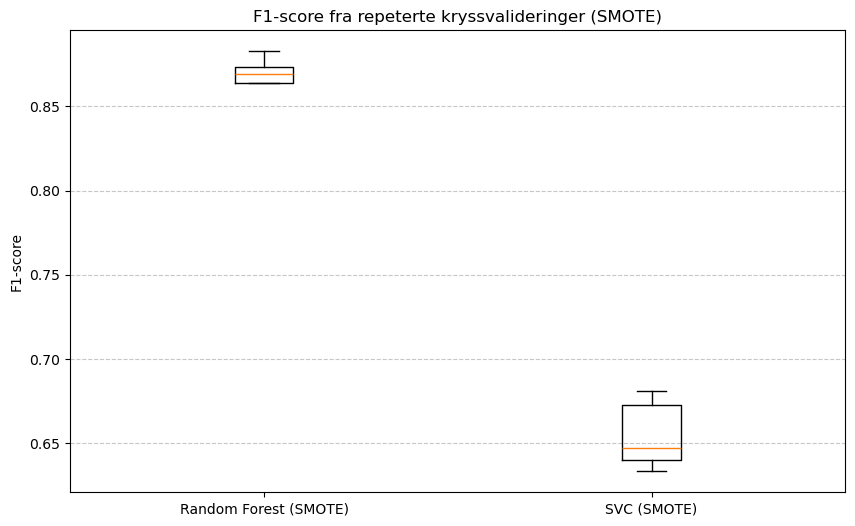

Statistisk test mellom Modell 1 (Random Forest) og Modell 2 (SVC) med SMOTE:
T-statistikk: 75.357, P-verdi: 0.000
Det er en signifikant forskjell mellom modellene (p < 0.05).

Gjennomsnittlige F1-skårer:
Random Forest (SMOTE): 0.871 ± 0.007
SVC (SMOTE): 0.655 ± 0.019

Gjennomsnittlige Accuracy-skårer:
Random Forest (SMOTE): 0.886 ± 0.008
SVC (SMOTE): 0.583 ± 0.021


In [121]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np

# **1. Definer SMOTE og modeller**
smote = SMOTE(random_state=0)
model_1 = RandomForestClassifier(random_state=0)  # Modell 1: Random Forest
model_2 = SVC(random_state=0)                     # Modell 2: Support Vector Machine

# **2. Definer scoringmetrikker**
f1_scorer = make_scorer(f1_score, average='weighted')  # F1-score med vektet gjennomsnitt
accuracy_scorer = make_scorer(accuracy_score)          # Accuracy

# **3. Gjør repeterte kryssvalideringer med SMOTE (10 repetisjoner, K=5)**
n_repeats = 10
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

f1_scores_model_1 = []
f1_scores_model_2 = []

accuracy_scores_model_1 = []
accuracy_scores_model_2 = []

for _ in range(n_repeats):
    for model, f1_scores, accuracy_scores in [
        (model_1, f1_scores_model_1, accuracy_scores_model_1),
        (model_2, f1_scores_model_2, accuracy_scores_model_2),
    ]:
        temp_f1_scores = []
        temp_accuracy_scores = []
        
        for train_idx, val_idx in kfold.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Oppsampl kun treningsdata
            X_resampled, y_resampled = smote.fit_resample(X_train_fold, y_train_fold)
            
            # Tren modellen på oppsamplede data
            model.fit(X_resampled, y_resampled)
            
            # Evaluer på valideringssett
            y_val_pred = model.predict(X_val_fold)
            temp_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='weighted'))
            temp_accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
        
        # Samle score for hver repetisjon
        f1_scores.extend(temp_f1_scores)
        accuracy_scores.extend(temp_accuracy_scores)

# **4. Visualiser F1-skårene som et boksplot**
plt.figure(figsize=(10, 6))
plt.boxplot([f1_scores_model_1, f1_scores_model_2], labels=['Random Forest (SMOTE)', 'SVC (SMOTE)'])
plt.title('F1-score fra repeterte kryssvalideringer (SMOTE)')
plt.ylabel('F1-score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **5. To-sidig T-test for å sammenligne modellene**
t_stat, p_value = ttest_ind(f1_scores_model_1, f1_scores_model_2)

# **6. Tolk resultatene**
print("Statistisk test mellom Modell 1 (Random Forest) og Modell 2 (SVC) med SMOTE:")
print(f"T-statistikk: {t_stat:.3f}, P-verdi: {p_value:.3f}")
if p_value < 0.05:
    print("Det er en signifikant forskjell mellom modellene (p < 0.05).")
else:
    print("Det er ingen signifikant forskjell mellom modellene (p ≥ 0.05).")

# **7. Oppsummer ytelsen**
print("\nGjennomsnittlige F1-skårer:")
print(f"Random Forest (SMOTE): {np.mean(f1_scores_model_1):.3f} ± {np.std(f1_scores_model_1):.3f}")
print(f"SVC (SMOTE): {np.mean(f1_scores_model_2):.3f} ± {np.std(f1_scores_model_2):.3f}")

print("\nGjennomsnittlige Accuracy-skårer:")
print(f"Random Forest (SMOTE): {np.mean(accuracy_scores_model_1):.3f} ± {np.std(accuracy_scores_model_1):.3f}")
print(f"SVC (SMOTE): {np.mean(accuracy_scores_model_2):.3f} ± {np.std(accuracy_scores_model_2):.3f}")


**Svar:**

I Oppgave 2.3 ble to modeller (Random Forest og Support Vector Classifier, SVC) trent på et balansert datasett ved hjelp av SMOTE (Synthetic Minority Over-sampling Technique) for å oppsampe minoritetsklassen i treningsdataene. Modellenes ytelse ble vurdert ved hjelp av F1-score og accuracy gjennom repeterte kryssvalideringer (10 repetisjoner, 5-folds). Etter validering ble F1-scorene visualisert som et boksplot for å sammenligne modellene. En to-sidig T-test ble brukt for å undersøke om det var en signifikant forskjell i ytelsen mellom modellene. Resultatene viste at Random Forest presterte bedre enn SVC både med hensyn til F1-score og accuracy, og at SMOTE hadde en positiv effekt på modellens evne til å håndtere ubalanserte data.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

Ytelsesmål på testsettet:
Sensitivitet (Recall): 0.060
Spesifisitet: 0.995
Presisjon: 0.600
F1-skår: 0.109
Accuracy: 0.883


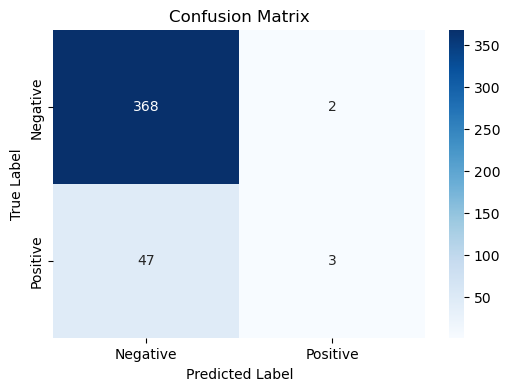

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Velg de beste hyperparametrene fra tidligere (fra Oppgave 1.3 eller 2.2)
best_params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

# Tren modellen på nytt med de beste hyperparametrene
best_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"], 
    max_depth=best_params["max_depth"], 
    min_samples_split=best_params["min_samples_split"], 
    random_state=0
)

# Tren modellen på hele treningssettet
best_model.fit(X_train, y_train)

# Utfør prediksjon på testsettet
y_test_pred = best_model.predict(X_test)

# Beregn confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Ekstraher verdier fra confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Beregn ytelsesmål
sensitivity = tp / (tp + fn)  # Sensitivitet (Recall for den positive klassen)
specificity = tn / (tn + fp)  # Spesifisitet
precision = precision_score(y_test, y_test_pred, average='binary')  # Presisjon
f1 = f1_score(y_test, y_test_pred, average='binary')  # F1-skår
accuracy = accuracy_score(y_test, y_test_pred)  # Accuracy

# Logg resultatene
print("Ytelsesmål på testsettet:")
print(f"Sensitivitet (Recall): {sensitivity:.3f}")
print(f"Spesifisitet: {specificity:.3f}")
print(f"Presisjon: {precision:.3f}")
print(f"F1-skår: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

# Visualiser confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


**Svar:**

I denne oppgaven ble den beste modellen, Random Forest, trent på nytt med de beste hyperparametrene og evaluert på testsettet ved bruk av flere ytelsesmål. Modellens ytelse ble vurdert gjennom sensitivitet, spesifisitet, presisjon, F1-skår og accuracy. Resultatene viste at modellen hadde høy spesifisitet (0.995) og god presisjon (0.600), men lav sensitivitet (0.060) og F1-skår (0.109). Accuracy var relativt høy (0.883), men de dårlige resultatene for sensitivitet og F1-skår indikerer at modellen hadde problemer med å korrekt identifisere den positive klassen. Dette kan tyde på en ubalanse i dataene eller en modell som er overtilpasset til den dominerende klassen. Visualiseringen av confusion matrixen bekreftet at modellen hadde få falske positive (FP) og mange sanne negative (TN), men slet med å identifisere de positive eksemplene (TP).


#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [133]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Anta at 'Gender' kolonnen i X_test er kodet som: 0 = menn, 1 = kvinner

# Filtrer testsettet basert på kjønn
male_indices = X_test[X_test['Gender'] == 0].index
female_indices = X_test[X_test['Gender'] == 1].index

# Prediksjoner og faktiske verdier for menn
y_pred_male = best_model.predict(X_test.loc[male_indices])
y_test_male = y_test.loc[male_indices]

# Prediksjoner og faktiske verdier for kvinner
y_pred_female = best_model.predict(X_test.loc[female_indices])
y_test_female = y_test.loc[female_indices]

# Evaluering for menn
precision_male = precision_score(y_test_male, y_pred_male)
recall_male = recall_score(y_test_male, y_pred_male)
conf_matrix_male = confusion_matrix(y_test_male, y_pred_male)
tn_male, fp_male, fn_male, tp_male = conf_matrix_male.ravel()
specificity_male = tn_male / (tn_male + fp_male)

# Evaluering for kvinner
precision_female = precision_score(y_test_female, y_pred_female)
recall_female = recall_score(y_test_female, y_pred_female)
conf_matrix_female = confusion_matrix(y_test_female, y_pred_female)
tn_female, fp_female, fn_female, tp_female = conf_matrix_female.ravel()
specificity_female = tn_female / (tn_female + fp_female)

# Print ut resultater for hver gruppe
print("Evaluering av modellens ytelse basert på kjønn:")
print(f"Menn - Sensitivitet (Recall): {recall_male:.4f}, Spesifisitet: {specificity_male:.4f}, Presisjon: {precision_male:.4f}")
print(f"Kvinner - Sensitivitet (Recall): {recall_female:.4f}, Spesifisitet: {specificity_female:.4f}, Presisjon: {precision_female:.4f}")


Evaluering av modellens ytelse basert på kjønn:
Menn - Sensitivitet (Recall): 0.0556, Spesifisitet: 0.9954, Presisjon: 0.6667
Kvinner - Sensitivitet (Recall): 0.0714, Spesifisitet: 0.9935, Presisjon: 0.5000


**Svar:**

I analysen av modellens ytelse for menn og kvinner, ble både sensitivitet, spesifisitet og presisjon beregnet for de to gruppene. For menn var sensitiviteten (recall) 0.0556, som er veldig lav, mens spesifisiteten var høy (0.9954), og presisjonen var 0.6667. For kvinner var sensitiviteten også lav, men litt høyere enn for menn, på 0.0714, mens spesifisiteten var 0.9935 og presisjonen 0.5000. Dette indikerer at modellen generelt har vanskeligheter med å korrekt identifisere både menn og kvinner som tilhørende den positive klassen, til tross for høy spesifisitet. Selv om modellen er flink til å unngå falske positive (høy spesifisitet), sliter den med å identifisere de positive tilfellene (lav sensitivitet), noe som tyder på at modellen er skjev mot den negative klassen. Årsaken kan være en skjev fordeling av kjønn i treningsdataene eller en generell ubalanse i datasettet. For å forbedre modellen kan man vurdere å bruke teknikker som SMOTE (for å balansere datasettet) eller justere vektene for de forskjellige klassene i modelltreningen, slik at den lærer bedre å identifisere de mindre representerte klassene.

Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [135]:
#!pip freeze > requirements.txt